# Introduction to Machine Learning 2
Na-Rae Han, 10/19/2019

General machine learning work flow:
1. Choose a class of model
2. Choose model hyperparameters
3. Fit the model to the training data ("training")
4. Use the model to predict labels for new data
    - If labels are known (test data, aka 'gold' data), evaluate the performance. 

### Three types of ML:
https://jakevdp.github.io/PythonDataScienceHandbook/05.01-what-is-machine-learning.html

1. Regression: predicting continuous values
2. Classification: predicting discrete labels
3. **Clustering: inferring labels on unlabeled data**  <-- This one below

In [11]:
# Turns on/off pretty printing 
%pprint

# Every returned Out[] is displayed, not just the last one. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Pretty printing has been turned OFF


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn               # sklearn is the ML package we will use
import seaborn as sns        # seaborn graphical package

## Clustering: a type of unsupervised learning

- Using sklearn's pre-loaded data set "20 Newsgroups" 
- Code below is adapted from sklearn's official tutorial: 
  http://scikit-learn.org/stable/auto_examples/text/document_clustering.html 

Topic-based clustering is our goal:  
- Given a set of documents that are written on 4 topics, can they be grouped into 4 clusters? 

We will try **K-means clustering** method. 
- A good introduction article: https://www.datascience.com/blog/k-means-clustering
- sklearn's documentation: http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html

In [1]:
from sklearn import metrics
from sklearn.cluster import KMeans

In [2]:
# TfidfVectorizer is essentially CountVectorizer + TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

### Data preparation step

In [3]:
from sklearn.datasets import fetch_20newsgroups

# We will use the same 4 categories
cats = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics']

# Not using train-test split. Because this is un-supervised! 
dataset = fetch_20newsgroups(subset='all', categories=cats, shuffle=True, random_state=12)

In [4]:
type(dataset)

sklearn.datasets.base.Bunch

In [5]:
dir(dataset)

['DESCR', 'data', 'description', 'filenames', 'target', 'target_names']

In [6]:
dataset.data[5]

'From: vis@world.std.com (Tom R Courtney)\nSubject: Re: Space Marketing would be wonderfull.\nOrganization: The World Public Access UNIX, Brookline, MA\nLines: 17\n\nIn some sense, I think that the folks who think the idea is wonderful, and the\nfolks who want to boycott anyone who has anything to do with this project are\nboth right.\n\nThat is, I think that space advertising is an interesting idea, and if someone\nwants to try it out, more power to them. However, a company may discover that\nthe cost of launch is not the only cost of advertising, and a company who \ngauged that ill will would lose them more revenue than the advertising would\ngain might decide to bow out of the project.\n\nI got incensed when I read that Carl Sagan called this idea an "abomination." \nI don\'t think that word means what he thinks it does. Children starving in the\nrichest country in the world is an abomination; an ad agency is at worst just\nin poor taste.\n\nTom Courtney\n\n'

In [7]:
dataset.target
dataset.target[5]
dataset.target_names

['comp.graphics', 'sci.space', 'soc.religion.christian', 'talk.religion.misc']

In [8]:
len(dataset.data)

3585

In [12]:
# In our case, WE KNOW TRUE VALUE OF K: 4 topics. 
# But in many real-life use cases, true number of clusters will not be known,
#  and user must experiment with different K values. 

true_k = np.unique(dataset.target).shape[0]
print(true_k)

4


In [13]:
# Ignore words found in over 50% of documents, ignore words found in just 1 document. 
# 1000 most frequent words, remove stop words. 
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, max_features=1000, stop_words='english')
X = vectorizer.fit_transform(dataset.data)

In [14]:
X[5]
print(X[5])
# 1x1000? "sparse matrix"? 

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 31 stored elements in Compressed Sparse Row format>

  (0, 204)	0.0672523411448
  (0, 746)	0.105033387862
  (0, 180)	0.137895061559
  (0, 899)	0.318946488968
  (0, 826)	0.194510523256
  (0, 289)	0.0790109160299
  (0, 292)	0.0753453600121
  (0, 474)	0.0720597593222
  (0, 382)	0.117968021464
  (0, 711)	0.103870512588
  (0, 957)	0.0980917306138
  (0, 982)	0.271846319562
  (0, 697)	0.124447255719
  (0, 53)	0.118728321999
  (0, 923)	0.138473219002
  (0, 16)	0.124447255719
  (0, 787)	0.131302647881
  (0, 887)	0.313694855686
  (0, 429)	0.351672218256
  (0, 689)	0.265838807771
  (0, 449)	0.130831997331
  (0, 959)	0.153887024417
  (0, 909)	0.119059351145
  (0, 671)	0.12915907751
  (0, 216)	0.297109201319
  (0, 235)	0.280127897997
  (0, 495)	0.14325935292
  (0, 160)	0.116086406394
  (0, 977)	0.120763749157
  (0, 553)	0.122679382187
  (0, 60)	0.155757332972


In [15]:
vectorizer.vocabulary_.get('space')
vectorizer.get_feature_names()[204]
vectorizer.get_feature_names()[180]

826

'com'

'children'

### Data preparation complete. Time to apply K-means

In [16]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, verbose=True)
km.fit(X)

Initialization complete
Iteration  0, inertia 6444.051
Iteration  1, inertia 3352.704
Iteration  2, inertia 3327.461
Iteration  3, inertia 3320.843
Iteration  4, inertia 3317.176
Iteration  5, inertia 3314.382
Iteration  6, inertia 3313.078
Iteration  7, inertia 3312.424
Iteration  8, inertia 3311.967
Iteration  9, inertia 3311.590
Iteration 10, inertia 3311.269
Iteration 11, inertia 3311.059
Iteration 12, inertia 3310.940
Iteration 13, inertia 3310.903
Iteration 14, inertia 3310.881
Iteration 15, inertia 3310.877
Converged at iteration 15: center shift 0.000000e+00 within tolerance 9.553371e-08


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=4, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)

In [17]:
# A bunch of metrics that compare target labels and labels as assigned by KM. 
print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataset.target, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(dataset.target, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(dataset.target, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(dataset.target, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Homogeneity: 0.491
Completeness: 0.505
V-measure: 0.498
Adjusted Rand-Index: 0.421
Silhouette Coefficient: 0.014


In [18]:
# Top terms ("features") as ranked by centroids
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: space nasa access henry digex pat gov toronto alaska shuttle
Cluster 1: graphics thanks university image posting host nntp file files ac
Cluster 2: com article christian university don church people just like know
Cluster 3: god jesus people christ sin christians bible believe hell christian


In [19]:
km.labels_[:20]        # Cluster labels as assigned by KMeans
dataset.target[:20]    # These are the real target labels
dataset.target_names

array([3, 0, 2, 0, 3, 0, 3, 2, 1, 1, 3, 0, 2, 3, 2, 1, 3, 2, 2, 1], dtype=int32)

array([2, 1, 2, 1, 2, 1, 2, 2, 2, 0, 2, 1, 2, 3, 2, 0, 3, 2, 3, 0])

['comp.graphics', 'sci.space', 'soc.religion.christian', 'talk.religion.misc']

### Round 2. Let's try 3 clusters this time. 

In [20]:
km2 = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=1, verbose=True)
km2.fit(X)

Initialization complete
Iteration  0, inertia 6474.808
Iteration  1, inertia 3391.382
Iteration  2, inertia 3371.295
Iteration  3, inertia 3351.429
Iteration  4, inertia 3340.756
Iteration  5, inertia 3335.742
Iteration  6, inertia 3334.882
Iteration  7, inertia 3334.693
Iteration  8, inertia 3334.614
Iteration  9, inertia 3334.555
Iteration 10, inertia 3334.515
Iteration 11, inertia 3334.490
Iteration 12, inertia 3334.474
Iteration 13, inertia 3334.463
Converged at iteration 13: center shift 0.000000e+00 within tolerance 9.553371e-08


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=3, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)

In [21]:
print("Top terms per cluster:")
order_centroids = km2.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(3):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()
# Are the clusters looking better? 
# CAVEAT: could be local optimum, re-run to change

Top terms per cluster:
Cluster 0: god jesus people com christian church bible christians christ don
Cluster 1: space nasa henry access digex gov pat toronto alaska shuttle
Cluster 2: com graphics university posting host nntp thanks know computer image


In [22]:
km2.labels_[:20]        # Cluster labels as assigned by KMeans
dataset.target[:20]     # These are the real target labels
dataset.target_names

array([0, 1, 2, 1, 0, 1, 0, 2, 2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 0, 2], dtype=int32)

array([2, 1, 2, 1, 2, 1, 2, 2, 2, 0, 2, 1, 2, 3, 2, 0, 3, 2, 3, 0])

['comp.graphics', 'sci.space', 'soc.religion.christian', 'talk.religion.misc']

In [23]:
# Newsgroup label -> KM label. Will need to adjust. 
labelmap = {0:0, 1:2, 2:1, 3:1}

target_conv = [labelmap[x] for x in dataset.target]
target_conv[:20]

[1, 2, 1, 2, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0]

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(target_conv, km2.labels_)
cm

array([[   2,    9,  962],
       [1234,    6,  385],
       [   8,  686,  293]])

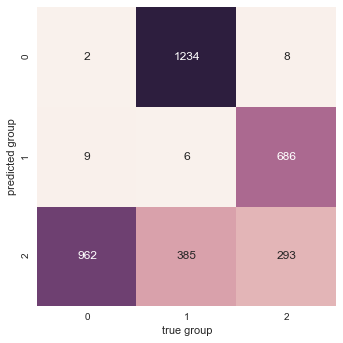

In [25]:
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true group')
plt.ylabel('predicted group')
plt.show()

### Question: Can we produce nifty clustering visuals
such as the ones in tutorial/documentation: 
- https://www.datascience.com/blog/k-means-clustering
- http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_iris_004.png

??

### Too Many Dimensions
This is where PCA (Principal Component Analysis) comes in. 
- Textbook chapter: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

### Testing on new, made up examples

In [27]:
#km2 doens't take direct strings
tests = ['sending a payload to the ISS', 'I met Santa Claus once']
preds = km2.predict(tests)
print(preds)
#???

ValueError: could not convert string to float: 'sending a payload to the ISS'

In [29]:
tests = ['sending a payload to the ISS', 'I met Santa Claus once']
tests_tfidf = vectorizer.transform(tests)    # Yep, need this
preds = km2.predict(tests_tfidf)
print(preds)
# this gives wrong outputs but eh okay

[2 2]
